In [1]:
import pandas as pd
import numpy as np
import os
import spacy
import string
import pickle as pkl
from nltk import ngrams
from collections import Counter
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
%matplotlib inline

## Data Loading

In [2]:
def load_data(folder_path, label): 
    scores = []
    data_list = []
    for file in os.listdir(folder_path):
        if file.endswith(".txt"):
            scores.append(int(file[file.find("_")+1:file.find(".")]))
            with open(folder_path+file) as f:
                data_list.append(f.read())
    
    labels = label*np.ones(len(scores))
    return data_list, labels, scores

In [3]:
def merge_data(data1, data2, label1, label2, score1, score2, split, shuffle, train_size=20000):
    data = data1+data2
    labels = np.concatenate([label1, label2]).tolist()
    scores = score1+score2
    
    if shuffle:
        np.random.seed(0)
        index = np.random.permutation(len(data))
        data = np.array(data)[index].tolist()
        labels = np.array(labels)[index].tolist()
        scores = np.array(scores)[index].tolist()
    
    if split:
        train_data = data[:train_size]
        val_data = data[train_size:]
        train_labels = labels[:train_size]
        val_labels = labels[train_size:]
        train_scores = scores[:train_size]
        val_scores = scores[train_size]
        return train_data, train_labels, train_scores, val_data, val_labels, val_scores
    
    return data, labels, scores

In [4]:
train_pos_path = os.getcwd()+'/aclImdb/train/pos/'
train_neg_path = os.getcwd()+'/aclImdb/train/neg/'
test_pos_path = os.getcwd()+'/aclImdb/test/pos/'
test_neg_path = os.getcwd()+'/aclImdb/test/neg/'

In [5]:
train_pos_data, train_pos_label, train_pos_scores = load_data(train_pos_path, 1)
train_neg_data, train_neg_label, train_neg_scores = load_data(train_neg_path, 0)
test_pos_data, test_pos_label, test_pos_scores = load_data(test_pos_path, 1)
test_neg_data, test_neg_label, test_neg_scores = load_data(test_neg_path, 0)

In [6]:
# train_data, train_labels, train_scores, \
# val_data, val_labels, val_scores = merge_data(train_pos_data, train_neg_data, train_pos_label, train_neg_label,
#                                               train_pos_scores, train_neg_scores, True, True)

In [7]:
test_data, test_labels, test_scores = \
merge_data(test_pos_data, test_neg_data, test_pos_label, test_neg_label,
                                              test_pos_scores, test_neg_scores, False, False)

In [8]:
# pkl.dump(train_data, open("train_data.p", "wb"))
# pkl.dump(train_labels, open("train_labels.p", "wb"))
# pkl.dump(train_scores, open("train_scores.p", "wb"))
# pkl.dump(val_data, open("val_data.p", "wb"))
# pkl.dump(val_labels, open("val_labels.p", "wb"))
# pkl.dump(val_scores, open("val_scores.p", "wb"))
train_data = pkl.load(open("train_data.p", "rb"))
train_labels = pkl.load(open("train_labels.p", "rb"))
train_scores = pkl.load(open("train_scores.p", "rb"))
val_data = pkl.load(open("val_data.p", "rb"))
val_labels = pkl.load(open("val_labels.p", "rb"))
val_scores = pkl.load(open("val_scores.p", "rb"))

## Data preprocessing (Tokenization)

In [9]:
tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation

def tokenize(sent, tokenization):
    tokens = tokenizer(sent)
    if tokenization:
        return [token.text.lower() for token in tokens if (token.text not in punctuations)]
    else:
        return [token.text for token in tokens]

### 1-gram (word)

In [10]:
def tokenize_dataset(dataset, tokenization):
    token_dataset = []
    all_tokens = []
    
    for sample in dataset:
        tokens = tokenize(sample, tokenization)
        token_dataset.append(tokens)
        all_tokens += tokens

    return token_dataset, all_tokens

In [11]:
train_data_tokens = pkl.load(open("train_data_tokens.p", "rb"))
all_train_tokens = pkl.load(open("all_train_tokens.p", "rb"))
val_data_tokens = pkl.load(open("val_data_tokens.p", "rb"))
test_data_tokens = pkl.load(open("test_data_tokens.p", "rb"))

print ("Train dataset size is {}".format(len(train_data_tokens)))
print ("Val dataset size is {}".format(len(val_data_tokens)))
print ("Test dataset size is {}".format(len(test_data_tokens)))
print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Total number of tokens in train dataset is 4809135


### 1-gram (word) no tokenization (lowercase & remove punctuations)

In [12]:
train_data_tokens_ntk = pkl.load(open("train_data_tokens_ntk.p", "rb"))
all_train_tokens_ntk = pkl.load(open("all_train_tokens_ntk.p", "rb"))
val_data_tokens_ntk = pkl.load(open("val_data_tokens_ntk.p", "rb"))
test_data_tokens_ntk = pkl.load(open("test_data_tokens_ntk.p", "rb"))

print ("Train dataset size is {}".format(len(train_data_tokens_ntk)))
print ("Val dataset size is {}".format(len(val_data_tokens_ntk)))
print ("Test dataset size is {}".format(len(test_data_tokens_ntk)))
print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens_ntk)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Total number of tokens in train dataset is 5439707


### 2-grams

In [13]:
def tokenize_dataset_ngram(dataset, n, tokenization):
    token_dataset = []
    all_tokens = []
    
    for sample in dataset:
        tokens = tokenize(sample, tokenization)
        n_grams = list(ngrams(tokens, n))
        token_dataset.append(n_grams)
        all_tokens += n_grams

    return token_dataset, all_tokens

In [14]:
train_data_tokens_n2 = pkl.load(open("train_data_tokens_n2.p", "rb"))
all_train_tokens_n2 = pkl.load(open("all_train_tokens_n2.p", "rb"))
val_data_tokens_n2 = pkl.load(open("val_data_tokens_n2.p", "rb"))
test_data_tokens_n2 = pkl.load(open("test_data_tokens_n2.p", "rb"))

print ("Train dataset size is {}".format(len(train_data_tokens_n2)))
print ("Val dataset size is {}".format(len(val_data_tokens_n2)))
print ("Test dataset size is {}".format(len(test_data_tokens_n2)))
print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens_n2)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Total number of tokens in train dataset is 4789135


### 2-grams no tokenization (lowercase & remove punctuation)

In [15]:
train_data_tokens_n2_ntk = pkl.load(open("train_data_tokens_n2_ntk.p", "rb"))
all_train_tokens_n2_ntk = pkl.load(open("all_train_tokens_n2_ntk.p", "rb"))
val_data_tokens_n2_ntk = pkl.load(open("val_data_tokens_n2_ntk.p", "rb"))
test_data_tokens_n2_ntk = pkl.load(open("test_data_tokens_n2_ntk.p", "rb"))

print ("Train dataset size is {}".format(len(train_data_tokens_n2_ntk)))
print ("Val dataset size is {}".format(len(val_data_tokens_n2_ntk)))
print ("Test dataset size is {}".format(len(test_data_tokens_n2_ntk)))
print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens_n2_ntk)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Total number of tokens in train dataset is 5419707


### 3-grams

In [16]:
train_data_tokens_n3 = pkl.load(open("train_data_tokens_n3.p", "rb"))
all_train_tokens_n3 = pkl.load(open("all_train_tokens_n3.p", "rb"))
val_data_tokens_n3 = pkl.load(open("val_data_tokens_n3.p", "rb"))
test_data_tokens_n3 = pkl.load(open("test_data_tokens_n3.p", "rb"))

print ("Train dataset size is {}".format(len(train_data_tokens_n3)))
print ("Val dataset size is {}".format(len(val_data_tokens_n3)))
print ("Test dataset size is {}".format(len(test_data_tokens_n3)))
print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens_n3)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Total number of tokens in train dataset is 4769135


### 3-grams no tokenization (lowercase & remove punctuation)

In [17]:
train_data_tokens_n3_ntk = pkl.load(open("train_data_tokens_n3_ntk.p", "rb"))
all_train_tokens_n3_ntk = pkl.load(open("all_train_tokens_n3_ntk.p", "rb"))
val_data_tokens_n3_ntk = pkl.load(open("val_data_tokens_n3_ntk.p", "rb"))
test_data_tokens_n3_ntk = pkl.load(open("test_data_tokens_n3_ntk.p", "rb"))

print ("Train dataset size is {}".format(len(train_data_tokens_n3_ntk)))
print ("Val dataset size is {}".format(len(val_data_tokens_n3_ntk)))
print ("Test dataset size is {}".format(len(test_data_tokens_n3_ntk)))
print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens_n3_ntk)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Total number of tokens in train dataset is 5399707


### 4-grams

In [18]:
train_data_tokens_n4 = pkl.load(open("train_data_tokens_n4.p", "rb"))
all_train_tokens_n4 = pkl.load(open("all_train_tokens_n4.p", "rb"))
val_data_tokens_n4 = pkl.load(open("val_data_tokens_n4.p", "rb"))
test_data_tokens_n4 = pkl.load(open("test_data_tokens_n4.p", "rb"))

print ("Train dataset size is {}".format(len(train_data_tokens_n4)))
print ("Val dataset size is {}".format(len(val_data_tokens_n4)))
print ("Test dataset size is {}".format(len(test_data_tokens_n4)))
print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens_n4)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Total number of tokens in train dataset is 4749135


### 4-grams no tokenization (lowercase & remove punctuation)

In [19]:
train_data_tokens_n4_ntk = pkl.load(open("train_data_tokens_n4_ntk.p", "rb"))
all_train_tokens_n4_ntk = pkl.load(open("all_train_tokens_n4_ntk.p", "rb"))
val_data_tokens_n4_ntk = pkl.load(open("val_data_tokens_n4_ntk.p", "rb"))
test_data_tokens_n4_ntk = pkl.load(open("test_data_tokens_n4_ntk.p", "rb"))

print ("Train dataset size is {}".format(len(train_data_tokens_n4_ntk)))
print ("Val dataset size is {}".format(len(val_data_tokens_n4_ntk)))
print ("Test dataset size is {}".format(len(test_data_tokens_n4_ntk)))
print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens_n4_ntk)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Total number of tokens in train dataset is 5379707


## Build vocab lists and transform data into indices lists

In [14]:
PAD_IDX = 0
UNK_IDX = 1

In [15]:
def build_vocab(all_tokens, max_vocab_size):
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

In [16]:
def token2index_dataset(tokens_data, token2id):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

### 1-gram (word)

In [17]:
max_vocab_size = 25000
token2id_n1, id2token_n1 = build_vocab(all_train_tokens, max_vocab_size)

In [18]:
train_data_indices_n1 = token2index_dataset(train_data_tokens, token2id_n1)
val_data_indices_n1 = token2index_dataset(val_data_tokens, token2id_n1)
test_data_indices_n1 = token2index_dataset(test_data_tokens, token2id_n1)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices_n1)))
print ("Val dataset size is {}".format(len(val_data_indices_n1)))
print ("Test dataset size is {}".format(len(test_data_indices_n1)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


### 1-gram (word) no tokenization

In [28]:
max_vocab_size = 25000
token2id_n1_ntk, id2token_n1_ntk = build_vocab(all_train_tokens_ntk, max_vocab_size = 25000)

In [29]:
train_data_indices_n1_ntk = token2index_dataset(train_data_tokens_ntk, token2id_n1_ntk)
val_data_indices_n1_ntk = token2index_dataset(val_data_tokens_ntk, token2id_n1_ntk)
test_data_indices_n1_ntk = token2index_dataset(test_data_tokens_ntk, token2id_n1_ntk)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices_n1_ntk)))
print ("Val dataset size is {}".format(len(val_data_indices_n1_ntk)))
print ("Test dataset size is {}".format(len(test_data_indices_n1_ntk)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


### 2-grams

In [30]:
max_vocab_size = 25000
token2id_n2, id2token_n2 = build_vocab(all_train_tokens_n2, max_vocab_size)

In [31]:
train_data_indices_n2 = token2index_dataset(train_data_tokens_n2, token2id_n2)
val_data_indices_n2 = token2index_dataset(val_data_tokens_n2, token2id_n2)
test_data_indices_n2 = token2index_dataset(test_data_tokens_n2, token2id_n2)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices_n2)))
print ("Val dataset size is {}".format(len(val_data_indices_n2)))
print ("Test dataset size is {}".format(len(test_data_indices_n2)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


### 2-grams no tokenization

In [32]:
max_vocab_size = 25000
token2id_n2_ntk, id2token_n2_ntk = build_vocab(all_train_tokens_n2_ntk, max_vocab_size)

In [33]:
train_data_indices_n2_ntk = token2index_dataset(train_data_tokens_n2_ntk, token2id_n2_ntk)
val_data_indices_n2_ntk = token2index_dataset(val_data_tokens_n2_ntk, token2id_n2_ntk)
test_data_indices_n2_ntk = token2index_dataset(test_data_tokens_n2_ntk, token2id_n2_ntk)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices_n2_ntk)))
print ("Val dataset size is {}".format(len(val_data_indices_n2_ntk)))
print ("Test dataset size is {}".format(len(test_data_indices_n2_ntk)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


### 3-grams

In [34]:
max_vocab_size = 25000
token2id_n3, id2token_n3 = build_vocab(all_train_tokens_n3, max_vocab_size)

In [35]:
train_data_indices_n3 = token2index_dataset(train_data_tokens_n3, token2id_n3)
val_data_indices_n3 = token2index_dataset(val_data_tokens_n3, token2id_n3)
test_data_indices_n3 = token2index_dataset(test_data_tokens_n3, token2id_n3)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices_n3)))
print ("Val dataset size is {}".format(len(val_data_indices_n3)))
print ("Test dataset size is {}".format(len(test_data_indices_n3)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


### 3-grams no tokenization

In [36]:
max_vocab_size = 25000
token2id_n3_ntk, id2token_n3_ntk = build_vocab(all_train_tokens_n3_ntk, max_vocab_size)

In [37]:
train_data_indices_n3_ntk = token2index_dataset(train_data_tokens_n3_ntk, token2id_n3_ntk)
val_data_indices_n3_ntk = token2index_dataset(val_data_tokens_n3_ntk, token2id_n3_ntk)
test_data_indices_n3_ntk = token2index_dataset(test_data_tokens_n3_ntk, token2id_n3_ntk)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices_n3_ntk)))
print ("Val dataset size is {}".format(len(val_data_indices_n3_ntk)))
print ("Test dataset size is {}".format(len(test_data_indices_n3_ntk)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


### 4-grams

In [38]:
max_vocab_size = 25000
token2id_n4, id2token_n4 = build_vocab(all_train_tokens_n4, max_vocab_size)

In [39]:
train_data_indices_n4 = token2index_dataset(train_data_tokens_n4, token2id_n4)
val_data_indices_n4 = token2index_dataset(val_data_tokens_n4, token2id_n4)
test_data_indices_n4 = token2index_dataset(test_data_tokens_n4, token2id_n4)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices_n4)))
print ("Val dataset size is {}".format(len(val_data_indices_n4)))
print ("Test dataset size is {}".format(len(test_data_indices_n4)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


### 4-grams no tokenization

In [40]:
max_vocab_size = 25000
token2id_n4_ntk, id2token_n4_ntk = build_vocab(all_train_tokens_n4_ntk, max_vocab_size)

In [41]:
train_data_indices_n4_ntk = token2index_dataset(train_data_tokens_n4_ntk, token2id_n4_ntk)
val_data_indices_n4_ntk = token2index_dataset(val_data_tokens_n4_ntk, token2id_n4_ntk)
test_data_indices_n4_ntk = token2index_dataset(test_data_tokens_n4_ntk, token2id_n4_ntk)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices_n4_ntk)))
print ("Val dataset size is {}".format(len(val_data_indices_n4_ntk)))
print ("Test dataset size is {}".format(len(test_data_indices_n4_ntk)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


## DataLoader

In [19]:
MAX_SENTENCE_LENGTH = 200

In [20]:
class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when yo-u call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

### 1-gram (word)

In [21]:
BATCH_SIZE = 32
train_dataset_n1 = NewsGroupDataset(train_data_indices_n1, train_labels)
train_loader_n1 = torch.utils.data.DataLoader(dataset=train_dataset_n1, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset_n1 = NewsGroupDataset(val_data_indices_n1, val_labels)
val_loader_n1 = torch.utils.data.DataLoader(dataset=val_dataset_n1, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset_n1 = NewsGroupDataset(test_data_indices_n1, test_labels)
test_loader_n1 = torch.utils.data.DataLoader(dataset=test_dataset_n1, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

### 1-gram (word) no tokenization

In [45]:
BATCH_SIZE = 32
train_dataset_n1_ntk = NewsGroupDataset(train_data_indices_n1_ntk, train_labels)
train_loader_n1_ntk = torch.utils.data.DataLoader(dataset=train_dataset_n1_ntk, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset_n1_ntk = NewsGroupDataset(val_data_indices_n1_ntk, val_labels)
val_loader_n1_ntk = torch.utils.data.DataLoader(dataset=val_dataset_n1_ntk, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset_n1_ntk = NewsGroupDataset(test_data_indices_n1_ntk, test_labels)
test_loader_n1_ntk = torch.utils.data.DataLoader(dataset=test_dataset_n1_ntk, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

### 2-grams

In [46]:
BATCH_SIZE = 32
train_dataset_n2 = NewsGroupDataset(train_data_indices_n2, train_labels)
train_loader_n2 = torch.utils.data.DataLoader(dataset=train_dataset_n2, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset_n2 = NewsGroupDataset(val_data_indices_n2, val_labels)
val_loader_n2 = torch.utils.data.DataLoader(dataset=val_dataset_n2, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset_n2 = NewsGroupDataset(test_data_indices_n2, test_labels)
test_loader_n2 = torch.utils.data.DataLoader(dataset=test_dataset_n2, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

### 2-grams no tokenization

In [47]:
BATCH_SIZE = 32
train_dataset_n2_ntk = NewsGroupDataset(train_data_indices_n2_ntk, train_labels)
train_loader_n2_ntk = torch.utils.data.DataLoader(dataset=train_dataset_n2_ntk, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset_n2_ntk = NewsGroupDataset(val_data_indices_n2_ntk, val_labels)
val_loader_n2_ntk = torch.utils.data.DataLoader(dataset=val_dataset_n2_ntk, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset_n2_ntk = NewsGroupDataset(test_data_indices_n2_ntk, test_labels)
test_loader_n2_ntk = torch.utils.data.DataLoader(dataset=test_dataset_n2_ntk, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

### 3-grams

In [48]:
BATCH_SIZE = 32
train_dataset_n3 = NewsGroupDataset(train_data_indices_n3, train_labels)
train_loader_n3 = torch.utils.data.DataLoader(dataset=train_dataset_n3, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset_n3 = NewsGroupDataset(val_data_indices_n3, val_labels)
val_loader_n3 = torch.utils.data.DataLoader(dataset=val_dataset_n3, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset_n3 = NewsGroupDataset(test_data_indices_n3, test_labels)
test_loader_n3 = torch.utils.data.DataLoader(dataset=test_dataset_n3, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

### 3-grams no tokenization

In [49]:
BATCH_SIZE = 32
train_dataset_n3_ntk = NewsGroupDataset(train_data_indices_n3_ntk, train_labels)
train_loader_n3_ntk = torch.utils.data.DataLoader(dataset=train_dataset_n3_ntk, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset_n3_ntk = NewsGroupDataset(val_data_indices_n3_ntk, val_labels)
val_loader_n3_ntk = torch.utils.data.DataLoader(dataset=val_dataset_n3_ntk, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset_n3_ntk = NewsGroupDataset(test_data_indices_n3_ntk, test_labels)
test_loader_n3_ntk = torch.utils.data.DataLoader(dataset=test_dataset_n3_ntk, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

### 4-grams

In [50]:
BATCH_SIZE = 32
train_dataset_n4 = NewsGroupDataset(train_data_indices_n4, train_labels)
train_loader_n4 = torch.utils.data.DataLoader(dataset=train_dataset_n4, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset_n4 = NewsGroupDataset(val_data_indices_n4, val_labels)
val_loader_n4 = torch.utils.data.DataLoader(dataset=val_dataset_n4, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset_n4 = NewsGroupDataset(test_data_indices_n4, test_labels)
test_loader_n4 = torch.utils.data.DataLoader(dataset=test_dataset_n4, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

### 4-grams no tokenization

In [51]:
BATCH_SIZE = 32
train_dataset_n4_ntk = NewsGroupDataset(train_data_indices_n4_ntk, train_labels)
train_loader_n4_ntk = torch.utils.data.DataLoader(dataset=train_dataset_n4_ntk, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

val_dataset_n4_ntk = NewsGroupDataset(val_data_indices_n4_ntk, val_labels)
val_loader_n4_ntk = torch.utils.data.DataLoader(dataset=val_dataset_n4_ntk, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=True)

test_dataset_n4_ntk = NewsGroupDataset(test_data_indices_n4_ntk, test_labels)
test_loader_n4_ntk = torch.utils.data.DataLoader(dataset=test_dataset_n4_ntk, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=newsgroup_collate_func,
                                           shuffle=False)

## Bag of N-gram Model & Training

In [22]:
class BagOfNgram(nn.Module):
    """
    BagOfNgram classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfNgram, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim, 2)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return out

In [23]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    
    return (100 * correct / total)

In [24]:
def train_proc(model, train_loader, val_loader, lr, adj, ep, optim, lr_decay=0, plt=False):
    criterion = torch.nn.CrossEntropyLoss()
    if optim == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    
    if adj:
        scheduler = StepLR(optimizer, step_size=1, gamma=lr_decay)
    
    train_ls = []
    for epoch in range(ep):
        if adj:
            scheduler.step()
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
            train_ls.append(loss)
            
#             if i > 0 and i % 100 == 0:
#                 val_acc, val_loss = test_model(val_loader, model)
#                 val_ls += val_loss
#                 print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
#                     epoch+1, ep, i+1, len(train_loader), val_acc))
    
    val_acc  = test_model(val_loader, model)
    print('Val Accuracy: {}'.format(val_acc))
    
    if plt:
        plt.plot(train_ls)
        plt.xlabel("n")
        plt.ylabel("Train Loss")
    
    return val_acc

### 1-gram (word)

In [55]:
emb_size = 100

In [56]:
model_n1 = BagOfNgram(len(id2token_n1), emb_size)
val_acc = train_proc(model_n1, train_loader_n1, val_loader_n1, 0.01, False, 3, 'Adam')

Val Accuracy: 86.32


In [57]:
model_n1 = BagOfNgram(len(id2token_n1), emb_size)
val_acc = train_proc(model_n1, train_loader_n1, val_loader_n1, 0.001, False, 3, 'Adam')

Val Accuracy: 86.72


In [58]:
model_n1 = BagOfNgram(len(id2token_n1), emb_size)
val_acc = train_proc(model_n1, train_loader_n1, val_loader_n1, 0.01, False, 5, 'Adam')

Val Accuracy: 85.14


In [59]:
model_n1 = BagOfNgram(len(id2token_n1), emb_size)
val_acc = train_proc(model_n1, train_loader_n1, val_loader_n1, 0.001, False, 5, 'Adam')

Val Accuracy: 88.06


In [60]:
model_n1 = BagOfNgram(len(id2token_n1), emb_size)
val_acc = train_proc(model_n1, train_loader_n1, val_loader_n1,  0.01, True, 3, 'Adam', 0.5)

Val Accuracy: 87.32


In [61]:
model_n1 = BagOfNgram(len(id2token_n1), emb_size)
val_acc = train_proc(model_n1, train_loader_n1, val_loader_n1, 0.01, True, 3, 'Adam', 0.1)

Val Accuracy: 88.4


In [62]:
model_n1 = BagOfNgram(len(id2token_n1), emb_size)
val_acc = train_proc(model_n1, train_loader_n1, val_loader_n1,  0.01, False, 3, 'SGD')

Val Accuracy: 65.84


In [63]:
model_n1 = BagOfNgram(len(id2token_n1), emb_size)
val_acc = train_proc(model_n1, train_loader_n1, val_loader_n1, 0.001, False, 3, 'SGD')

Val Accuracy: 63.42


In [64]:
model_n1 = BagOfNgram(len(id2token_n1), emb_size)
val_acc = train_proc(model_n1, train_loader_n1, val_loader_n1,  0.01, False, 5, 'SGD')

Val Accuracy: 66.9


In [65]:
model_n1 = BagOfNgram(len(id2token_n1), emb_size)
val_acc = train_proc(model_n1, train_loader_n1, val_loader_n1,  0.001, False, 5, 'SGD')

Val Accuracy: 62.34


In [66]:
model_n1 = BagOfNgram(len(id2token_n1), emb_size)
val_acc = train_proc(model_n1, train_loader_n1, val_loader_n1,  0.01, True, 3, 'SGD', 0.5)

Val Accuracy: 66.1


In [67]:
model_n1 = BagOfNgram(len(id2token_n1), emb_size)
val_acc = train_proc(model_n1, train_loader_n1, val_loader_n1,  0.01, True, 3, 'SGD', 0.1)

Val Accuracy: 63.18


In [68]:
emb_size = 200

In [69]:
model_n1 = BagOfNgram(len(id2token_n1), emb_size)
val_acc = train_proc(model_n1, train_loader_n1, val_loader_n1, 0.01, False, 3, 'Adam')

Val Accuracy: 85.54


In [70]:
model_n1 = BagOfNgram(len(id2token_n1), emb_size)
val_acc = train_proc(model_n1, train_loader_n1, val_loader_n1,  0.001, False, 3, 'Adam')

Val Accuracy: 87.7


In [71]:
model_n1 = BagOfNgram(len(id2token_n1), emb_size)
val_acc = train_proc(model_n1, train_loader_n1, val_loader_n1, 0.01, False, 5, 'Adam')

Val Accuracy: 84.88


In [72]:
model_n1 = BagOfNgram(len(id2token_n1), emb_size)
val_acc = train_proc(model_n1, train_loader_n1, val_loader_n1, 0.001, False, 5, 'Adam')

Val Accuracy: 88.42


In [73]:
model_n1 = BagOfNgram(len(id2token_n1), emb_size)
val_acc = train_proc(model_n1, train_loader_n1, val_loader_n1, 0.01, True, 3, 'Adam', 0.5)

Val Accuracy: 87.36


In [74]:
model_n1 = BagOfNgram(len(id2token_n1), emb_size)
val_acc = train_proc(model_n1, train_loader_n1, val_loader_n1,  0.01, True, 3, 'Adam', 0.1)

Val Accuracy: 88.3


In [75]:
model_n1 = BagOfNgram(len(id2token_n1), emb_size)
val_acc = train_proc(model_n1, train_loader_n1, val_loader_n1, 0.01, False, 3, 'SGD')

Val Accuracy: 69.42


In [76]:
model_n1 = BagOfNgram(len(id2token_n1), emb_size)
val_acc = train_proc(model_n1, train_loader_n1, val_loader_n1,  0.001, False, 3, 'SGD')

Val Accuracy: 65.52


In [77]:
model_n1 = BagOfNgram(len(id2token_n1), emb_size)
val_acc = train_proc(model_n1, train_loader_n1, val_loader_n1,  0.01, False, 5, 'SGD')

Val Accuracy: 71.22


In [78]:
model_n1 = BagOfNgram(len(id2token_n1), emb_size)
val_acc = train_proc(model_n1, train_loader_n1, val_loader_n1,  0.001, False, 5, 'SGD')

Val Accuracy: 64.94


In [79]:
model_n1 = BagOfNgram(len(id2token_n1), emb_size)
val_acc = train_proc(model_n1, train_loader_n1, val_loader_n1,  0.01, True, 3, 'SGD', 0.5)

Val Accuracy: 67.18


In [80]:
model_n1 = BagOfNgram(len(id2token_n1), emb_size)
val_acc = train_proc(model_n1, train_loader_n1, val_loader_n1,  0.01, True, 3, 'SGD', 0.1)

Val Accuracy: 67.72


### 1-gram (word) no tokenizaton

In [81]:
emb_size = 100

In [82]:
model_n1_ntk = BagOfNgram(len(id2token_n1_ntk), emb_size)
val_acc = train_proc(model_n1_ntk, train_loader_n1_ntk, val_loader_n1_ntk, 0.01, False, 3, 'Adam')

Val Accuracy: 86.12


In [83]:
model_n1_ntk = BagOfNgram(len(id2token_n1_ntk), emb_size)
val_acc = train_proc(model_n1_ntk, train_loader_n1_ntk, val_loader_n1_ntk, 0.001, False, 3, 'Adam')

Val Accuracy: 85.94


In [84]:
model_n1_ntk = BagOfNgram(len(id2token_n1_ntk), emb_size)
val_acc = train_proc(model_n1_ntk, train_loader_n1_ntk, val_loader_n1_ntk, 0.01, False, 5, 'Adam')

Val Accuracy: 85.1


In [85]:
model_n1_ntk = BagOfNgram(len(id2token_n1_ntk), emb_size)
val_acc = train_proc(model_n1_ntk, train_loader_n1_ntk, val_loader_n1_ntk,  0.001, False, 5, 'Adam')

Val Accuracy: 88.06


In [86]:
model_n1_ntk = BagOfNgram(len(id2token_n1_ntk), emb_size)
val_acc = train_proc(model_n1_ntk, train_loader_n1_ntk, val_loader_n1_ntk, 0.01, True, 3, 'Adam', 0.5)

Val Accuracy: 87.66


In [87]:
model_n1_ntk = BagOfNgram(len(id2token_n1_ntk), emb_size)
val_acc = train_proc(model_n1_ntk, train_loader_n1_ntk, val_loader_n1_ntk, 0.01, True, 3, 'Adam', 0.1)

Val Accuracy: 87.78


In [88]:
model_n1_ntk = BagOfNgram(len(id2token_n1_ntk), emb_size)
val_acc = train_proc(model_n1_ntk, train_loader_n1_ntk, val_loader_n1_ntk,  0.01, False, 3, 'SGD')

Val Accuracy: 66.94


In [89]:
model_n1_ntk = BagOfNgram(len(id2token_n1_ntk), emb_size)
val_acc = train_proc(model_n1_ntk, train_loader_n1_ntk, val_loader_n1_ntk,  0.001, False, 3, 'SGD')

Val Accuracy: 61.2


In [90]:
model_n1_ntk = BagOfNgram(len(id2token_n1_ntk), emb_size)
val_acc = train_proc(model_n1_ntk, train_loader_n1_ntk, val_loader_n1_ntk, 0.01, False, 5, 'SGD')

Val Accuracy: 67.02


In [91]:
model_n1_ntk = BagOfNgram(len(id2token_n1_ntk), emb_size)
val_acc = train_proc(model_n1_ntk, train_loader_n1_ntk, val_loader_n1_ntk, 0.001, False, 5, 'SGD')

Val Accuracy: 60.72


In [92]:
model_n1_ntk = BagOfNgram(len(id2token_n1_ntk), emb_size)
val_acc = train_proc(model_n1_ntk, train_loader_n1_ntk, val_loader_n1_ntk, 0.01, True, 3, 'SGD', 0.5)

Val Accuracy: 65.66


In [93]:
model_n1_ntk = BagOfNgram(len(id2token_n1_ntk), emb_size)
val_acc = train_proc(model_n1_ntk, train_loader_n1_ntk, val_loader_n1_ntk, 0.01, True, 3, 'SGD', 0.1)

Val Accuracy: 62.52


In [94]:
emb_size = 200

In [95]:
model_n1_ntk = BagOfNgram(len(id2token_n1_ntk), emb_size)
val_acc = train_proc(model_n1_ntk, train_loader_n1_ntk, val_loader_n1_ntk,  0.01, False, 3, 'Adam')

Val Accuracy: 84.7


In [96]:
model_n1_ntk = BagOfNgram(len(id2token_n1_ntk), emb_size)
val_acc = train_proc(model_n1_ntk, train_loader_n1_ntk, val_loader_n1_ntk, 0.001, False, 3, 'Adam')

Val Accuracy: 87.06


In [97]:
model_n1_ntk = BagOfNgram(len(id2token_n1_ntk), emb_size)
val_acc = train_proc(model_n1_ntk, train_loader_n1_ntk, val_loader_n1_ntk, 0.01, False, 5, 'Adam')

Val Accuracy: 84.84


In [98]:
model_n1_ntk = BagOfNgram(len(id2token_n1_ntk), emb_size)
val_acc = train_proc(model_n1_ntk, train_loader_n1_ntk, val_loader_n1_ntk, 0.001, False, 5, 'Adam')

Val Accuracy: 87.12


In [99]:
model_n1_ntk = BagOfNgram(len(id2token_n1_ntk), emb_size)
val_acc = train_proc(model_n1_ntk, train_loader_n1_ntk, val_loader_n1_ntk, 0.01, True, 3, 'Adam', 0.5)

Val Accuracy: 86.78


In [100]:
model_n1_ntk = BagOfNgram(len(id2token_n1_ntk), emb_size)
val_acc = train_proc(model_n1_ntk, train_loader_n1_ntk, val_loader_n1_ntk, 0.01, True, 3, 'Adam', 0.1)

Val Accuracy: 87.88


In [101]:
model_n1_ntk = BagOfNgram(len(id2token_n1_ntk), emb_size)
val_acc = train_proc(model_n1_ntk, train_loader_n1_ntk, val_loader_n1_ntk,  0.01, False, 3, 'SGD')

Val Accuracy: 69.16


In [102]:
model_n1_ntk = BagOfNgram(len(id2token_n1_ntk), emb_size)
val_acc = train_proc(model_n1_ntk, train_loader_n1_ntk, val_loader_n1_ntk,  0.001, False, 3, 'SGD')

Val Accuracy: 63.34


In [103]:
model_n1_ntk = BagOfNgram(len(id2token_n1_ntk), emb_size)
val_acc = train_proc(model_n1_ntk, train_loader_n1_ntk, val_loader_n1_ntk, 0.01, False, 5, 'SGD')

Val Accuracy: 71.2


In [104]:
model_n1_ntk = BagOfNgram(len(id2token_n1_ntk), emb_size)
val_acc = train_proc(model_n1_ntk, train_loader_n1_ntk, val_loader_n1_ntk,  0.001, False, 5, 'SGD')

Val Accuracy: 65.3


In [105]:
model_n1_ntk = BagOfNgram(len(id2token_n1_ntk), emb_size)
val_acc = train_proc(model_n1_ntk, train_loader_n1_ntk, val_loader_n1_ntk,  0.01, True, 3, 'SGD', 0.5)

Val Accuracy: 67.4


In [106]:
model_n1_ntk = BagOfNgram(len(id2token_n1_ntk), emb_size)
val_acc = train_proc(model_n1_ntk, train_loader_n1_ntk, val_loader_n1_ntk, 0.01, True, 3, 'SGD', 0.1)

Val Accuracy: 66.32


### 2-grams

In [107]:
emb_size = 100

In [108]:
model_n2 = BagOfNgram(len(id2token_n2), emb_size)
val_acc = train_proc(model_n2, train_loader_n2, val_loader_n2, 0.01, False, 3, 'Adam')

Val Accuracy: 83.54


In [109]:
model_n2 = BagOfNgram(len(id2token_n2), emb_size)
val_acc = train_proc(model_n2, train_loader_n2, val_loader_n2, 0.001, False, 3, 'Adam')

Val Accuracy: 83.6


In [110]:
model_n2 = BagOfNgram(len(id2token_n2), emb_size)
val_acc = train_proc(model_n2, train_loader_n2, val_loader_n2, 0.01, False, 5, 'Adam')

Val Accuracy: 83.46


In [111]:
model_n2 = BagOfNgram(len(id2token_n2), emb_size)
val_acc = train_proc(model_n2, train_loader_n2, val_loader_n2, 0.001, False, 5, 'Adam')

Val Accuracy: 84.84


In [112]:
model_n2 = BagOfNgram(len(id2token_n2), emb_size)
val_acc = train_proc(model_n2, train_loader_n2, val_loader_n2, 0.01, True, 3, 'Adam', 0.5)

Val Accuracy: 85.08


In [113]:
model_n2 = BagOfNgram(len(id2token_n2), emb_size)
val_acc = train_proc(model_n2, train_loader_n2, val_loader_n2, 0.01, True, 3, 'Adam', 0.1)

Val Accuracy: 85.3


In [114]:
model_n2 = BagOfNgram(len(id2token_n2), emb_size)
val_acc = train_proc(model_n2, train_loader_n2, val_loader_n2, 0.01, False, 3, 'SGD')

Val Accuracy: 55.98


In [115]:
model_n2 = BagOfNgram(len(id2token_n2), emb_size)
val_acc = train_proc(model_n2, train_loader_n2, val_loader_n2, 0.001, False, 3, 'SGD')

Val Accuracy: 55.0


In [116]:
model_n2 = BagOfNgram(len(id2token_n2), emb_size)
val_acc = train_proc(model_n2, train_loader_n2, val_loader_n2, 0.01, False, 5, 'SGD')

Val Accuracy: 60.6


In [117]:
model_n2 = BagOfNgram(len(id2token_n2), emb_size)
val_acc = train_proc(model_n2, train_loader_n2, val_loader_n2, 0.001, False, 5, 'SGD')

Val Accuracy: 53.74


In [118]:
model_n2 = BagOfNgram(len(id2token_n2), emb_size)
val_acc = train_proc(model_n2, train_loader_n2, val_loader_n2, 0.01, True, 3, 'SGD', 0.5)

Val Accuracy: 56.6


In [119]:
model_n2 = BagOfNgram(len(id2token_n2), emb_size)
val_acc = train_proc(model_n2, train_loader_n2, val_loader_n2, 0.01, True, 3, 'SGD', 0.1)

Val Accuracy: 57.28


In [120]:
emb_size = 200

In [121]:
model_n2 = BagOfNgram(len(id2token_n2), emb_size)
val_acc = train_proc(model_n2, train_loader_n2, val_loader_n2, 0.01, False, 3, 'Adam')

Val Accuracy: 82.98


In [122]:
model_n2 = BagOfNgram(len(id2token_n2), emb_size)
val_acc = train_proc(model_n2, train_loader_n2, val_loader_n2, 0.001, False, 3, 'Adam')

Val Accuracy: 85.04


In [123]:
model_n2 = BagOfNgram(len(id2token_n2), emb_size)
val_acc = train_proc(model_n2, train_loader_n2, val_loader_n2, 0.01, False, 5, 'Adam')

Val Accuracy: 82.6


In [124]:
model_n2 = BagOfNgram(len(id2token_n2), emb_size)
val_acc = train_proc(model_n2, train_loader_n2, val_loader_n2, 0.001, False, 5, 'Adam')

Val Accuracy: 85.68


In [125]:
model_n2 = BagOfNgram(len(id2token_n2), emb_size)
val_acc = train_proc(model_n2, train_loader_n2, val_loader_n2, 0.01, True, 3, 'Adam', 0.5)

Val Accuracy: 84.72


In [126]:
model_n2 = BagOfNgram(len(id2token_n2), emb_size)
val_acc = train_proc(model_n2, train_loader_n2, val_loader_n2, 0.01, True, 3, 'Adam', 0.1)

Val Accuracy: 85.38


In [127]:
model_n2 = BagOfNgram(len(id2token_n2), emb_size)
val_acc = train_proc(model_n2, train_loader_n2, val_loader_n2, 0.01, False, 3, 'SGD')

Val Accuracy: 54.34


In [128]:
model_n2 = BagOfNgram(len(id2token_n2), emb_size)
val_acc = train_proc(model_n2, train_loader_n2, val_loader_n2, 0.001, False, 3, 'SGD')

Val Accuracy: 52.54


In [129]:
model_n2 = BagOfNgram(len(id2token_n2), emb_size)
val_acc = train_proc(model_n2, train_loader_n2, val_loader_n2, 0.01, False, 5, 'SGD')

Val Accuracy: 52.6


In [130]:
model_n2 = BagOfNgram(len(id2token_n2), emb_size)
val_acc = train_proc(model_n2, train_loader_n2, val_loader_n2, 0.001, False, 5, 'SGD')

Val Accuracy: 59.56


In [131]:
model_n2 = BagOfNgram(len(id2token_n2), emb_size)
val_acc = train_proc(model_n2, train_loader_n2, val_loader_n2, 0.01, True, 3, 'SGD', 0.5)

Val Accuracy: 57.06


In [132]:
model_n2 = BagOfNgram(len(id2token_n2), emb_size)
val_acc = train_proc(model_n2, train_loader_n2, val_loader_n2, 0.01, True, 3, 'SGD', 0.1)

Val Accuracy: 60.64


### 2-grams no tokenization

In [133]:
emb_size = 100

In [134]:
model_n2_ntk = BagOfNgram(len(id2token_n2_ntk), emb_size)
val_acc = train_proc(model_n2_ntk, train_loader_n2_ntk, val_loader_n2_ntk, 0.01, False, 3, 'Adam')

Val Accuracy: 83.04


In [135]:
model_n2_ntk = BagOfNgram(len(id2token_n2_ntk), emb_size)
val_acc = train_proc(model_n2_ntk, train_loader_n2_ntk, val_loader_n2_ntk, 0.001, False, 3, 'Adam')

Val Accuracy: 84.06


In [136]:
model_n2_ntk = BagOfNgram(len(id2token_n2_ntk), emb_size)
val_acc = train_proc(model_n2_ntk, train_loader_n2_ntk, val_loader_n2_ntk, 0.01, False, 5, 'Adam')

Val Accuracy: 83.22


In [137]:
model_n2_ntk = BagOfNgram(len(id2token_n2_ntk), emb_size)
val_acc = train_proc(model_n2_ntk, train_loader_n2_ntk, val_loader_n2_ntk, 0.001, False, 5, 'Adam')

Val Accuracy: 85.1


In [138]:
model_n2_ntk = BagOfNgram(len(id2token_n2_ntk), emb_size)
val_acc = train_proc(model_n2_ntk, train_loader_n2_ntk, val_loader_n2_ntk, 0.01, True, 3, 'Adam', 0.5)

Val Accuracy: 84.84


In [139]:
model_n2_ntk = BagOfNgram(len(id2token_n2_ntk), emb_size)
val_acc = train_proc(model_n2_ntk, train_loader_n2_ntk, val_loader_n2_ntk, 0.01, True, 3, 'Adam', 0.1)

Val Accuracy: 85.24


In [140]:
model_n2_ntk = BagOfNgram(len(id2token_n2_ntk), emb_size)
val_acc = train_proc(model_n2_ntk, train_loader_n2_ntk, val_loader_n2_ntk, 0.01, False, 3, 'SGD')

Val Accuracy: 51.96


In [141]:
model_n2_ntk = BagOfNgram(len(id2token_n2_ntk), emb_size)
val_acc = train_proc(model_n2_ntk, train_loader_n2_ntk, val_loader_n2_ntk, 0.001, False, 3, 'SGD')

Val Accuracy: 52.1


In [142]:
model_n2_ntk = BagOfNgram(len(id2token_n2_ntk), emb_size)
val_acc = train_proc(model_n2_ntk, train_loader_n2_ntk, val_loader_n2_ntk, 0.01, False, 5, 'SGD')

Val Accuracy: 58.16


In [143]:
model_n2_ntk = BagOfNgram(len(id2token_n2_ntk), emb_size)
val_acc = train_proc(model_n2_ntk, train_loader_n2_ntk, val_loader_n2_ntk, 0.001, False, 5, 'SGD')

Val Accuracy: 53.18


In [144]:
model_n2_ntk = BagOfNgram(len(id2token_n2_ntk), emb_size)
val_acc = train_proc(model_n2_ntk, train_loader_n2_ntk, val_loader_n2_ntk, 0.01, True, 3, 'SGD', 0.5)

Val Accuracy: 56.0


In [145]:
model_n2_ntk = BagOfNgram(len(id2token_n2_ntk), emb_size)
val_acc = train_proc(model_n2_ntk, train_loader_n2_ntk, val_loader_n2_ntk, 0.01, True, 5, 'SGD', 0.1)

Val Accuracy: 55.6


In [146]:
emb_size = 200

In [147]:
model_n2_ntk = BagOfNgram(len(id2token_n2_ntk), emb_size)
val_acc = train_proc(model_n2_ntk, train_loader_n2_ntk, val_loader_n2_ntk, 0.01, False, 3, 'Adam')

Val Accuracy: 83.2


In [148]:
model_n2_ntk = BagOfNgram(len(id2token_n2_ntk), emb_size)
val_acc = train_proc(model_n2_ntk, train_loader_n2_ntk, val_loader_n2_ntk, 0.001, False, 3, 'Adam')

Val Accuracy: 84.2


In [149]:
model_n2_ntk = BagOfNgram(len(id2token_n2_ntk), emb_size)
val_acc = train_proc(model_n2_ntk, train_loader_n2_ntk, val_loader_n2_ntk, 0.01, False, 5, 'Adam')

Val Accuracy: 82.46


In [150]:
model_n2_ntk = BagOfNgram(len(id2token_n2_ntk), emb_size)
val_acc = train_proc(model_n2_ntk, train_loader_n2_ntk, val_loader_n2_ntk, 0.001, False, 5, 'Adam')

Val Accuracy: 85.14


In [151]:
model_n2_ntk = BagOfNgram(len(id2token_n2_ntk), emb_size)
val_acc = train_proc(model_n2_ntk, train_loader_n2_ntk, val_loader_n2_ntk, 0.01, True, 3, 'Adam', 0.5)

Val Accuracy: 84.34


In [152]:
model_n2_ntk = BagOfNgram(len(id2token_n2_ntk), emb_size)
val_acc = train_proc(model_n2_ntk, train_loader_n2_ntk, val_loader_n2_ntk, 0.01, True, 3, 'Adam', 0.1)

Val Accuracy: 84.78


In [153]:
model_n2_ntk = BagOfNgram(len(id2token_n2_ntk), emb_size)
val_acc = train_proc(model_n2_ntk, train_loader_n2_ntk, val_loader_n2_ntk, 0.01, False, 3, 'SGD')

Val Accuracy: 59.2


In [154]:
model_n2_ntk = BagOfNgram(len(id2token_n2_ntk), emb_size)
val_acc = train_proc(model_n2_ntk, train_loader_n2_ntk, val_loader_n2_ntk, 0.001, False, 3, 'SGD')

Val Accuracy: 56.56


In [155]:
model_n2_ntk = BagOfNgram(len(id2token_n2_ntk), emb_size)
val_acc = train_proc(model_n2_ntk, train_loader_n2_ntk, val_loader_n2_ntk, 0.01, False, 5, 'SGD')

Val Accuracy: 62.2


In [156]:
model_n2_ntk = BagOfNgram(len(id2token_n2_ntk), emb_size)
val_acc = train_proc(model_n2_ntk, train_loader_n2_ntk, val_loader_n2_ntk, 0.001, False, 5, 'SGD')

Val Accuracy: 56.86


In [157]:
model_n2_ntk = BagOfNgram(len(id2token_n2_ntk), emb_size)
val_acc = train_proc(model_n2_ntk, train_loader_n2_ntk, val_loader_n2_ntk, 0.01, True, 3, 'SGD', 0.5)

Val Accuracy: 61.32


In [158]:
model_n2_ntk = BagOfNgram(len(id2token_n2_ntk), emb_size)
val_acc = train_proc(model_n2_ntk, train_loader_n2_ntk, val_loader_n2_ntk, 0.01, True, 5, 'SGD', 0.1)

Val Accuracy: 59.7


### 3-grams

In [159]:
emb_size = 100

In [160]:
model_n3 = BagOfNgram(len(id2token_n3), emb_size)
val_acc = train_proc(model_n3, train_loader_n3, val_loader_n3, 0.01, False, 3, 'Adam')

Val Accuracy: 78.18


In [161]:
model_n3 = BagOfNgram(len(id2token_n3), emb_size)
val_acc = train_proc(model_n3, train_loader_n3, val_loader_n3, 0.001, False, 3, 'Adam')

Val Accuracy: 76.18


In [162]:
model_n3 = BagOfNgram(len(id2token_n3), emb_size)
val_acc = train_proc(model_n3, train_loader_n3, val_loader_n3, 0.01, False, 5, 'Adam')

Val Accuracy: 77.54


In [163]:
model_n3 = BagOfNgram(len(id2token_n3), emb_size)
val_acc = train_proc(model_n3, train_loader_n3, val_loader_n3, 0.001, False, 5, 'Adam')

Val Accuracy: 78.44


In [164]:
model_n3 = BagOfNgram(len(id2token_n3), emb_size)
val_acc = train_proc(model_n3, train_loader_n3, val_loader_n3, 0.01, True, 3, 'Adam', 0.5)

Val Accuracy: 79.74


In [165]:
model_n3 = BagOfNgram(len(id2token_n3), emb_size)
val_acc = train_proc(model_n3, train_loader_n3, val_loader_n3, 0.01, True, 3, 'Adam', 0.1)

Val Accuracy: 80.44


In [166]:
model_n3 = BagOfNgram(len(id2token_n3), emb_size)
val_acc = train_proc(model_n3, train_loader_n3, val_loader_n3, 0.01, False, 3, 'SGD')

Val Accuracy: 50.34


In [167]:
model_n3 = BagOfNgram(len(id2token_n3), emb_size)
val_acc = train_proc(model_n3, train_loader_n3, val_loader_n3, 0.001, False, 3, 'SGD')

Val Accuracy: 50.18


In [168]:
model_n3 = BagOfNgram(len(id2token_n3), emb_size)
val_acc = train_proc(model_n3, train_loader_n3, val_loader_n3, 0.01, False, 5, 'SGD')

Val Accuracy: 54.8


In [169]:
model_n3 = BagOfNgram(len(id2token_n3), emb_size)
val_acc = train_proc(model_n3, train_loader_n3, val_loader_n3, 0.001, False, 5, 'SGD')

Val Accuracy: 50.56


In [170]:
model_n3 = BagOfNgram(len(id2token_n3), emb_size)
val_acc = train_proc(model_n3, train_loader_n3, val_loader_n3, 0.01, True, 3, 'SGD', 0.5)

Val Accuracy: 52.2


In [171]:
model_n3 = BagOfNgram(len(id2token_n3), emb_size)
val_acc = train_proc(model_n3, train_loader_n3, val_loader_n3, 0.01, True, 3, 'SGD', 0.1)

Val Accuracy: 54.56


In [172]:
emb_size = 200

In [173]:
model_n3 = BagOfNgram(len(id2token_n3), emb_size)
val_acc = train_proc(model_n3, train_loader_n3, val_loader_n3, 0.01, False, 3, 'Adam')

Val Accuracy: 76.58


In [174]:
model_n3 = BagOfNgram(len(id2token_n3), emb_size)
val_acc = train_proc(model_n3, train_loader_n3, val_loader_n3, 0.001, False, 3, 'Adam')

Val Accuracy: 78.02


In [175]:
model_n3 = BagOfNgram(len(id2token_n3), emb_size)
val_acc = train_proc(model_n3, train_loader_n3, val_loader_n3, 0.01, False, 5, 'Adam')

Val Accuracy: 77.16


In [176]:
model_n3 = BagOfNgram(len(id2token_n3), emb_size)
val_acc = train_proc(model_n3, train_loader_n3, val_loader_n3, 0.001, False, 5, 'Adam')

Val Accuracy: 79.84


In [177]:
model_n3 = BagOfNgram(len(id2token_n3), emb_size)
val_acc = train_proc(model_n3, train_loader_n3, val_loader_n3, 0.01, True, 3, 'Adam', 0.5)

Val Accuracy: 79.86


In [178]:
model_n3 = BagOfNgram(len(id2token_n3), emb_size)
val_acc = train_proc(model_n3, train_loader_n3, val_loader_n3, 0.01, True, 3, 'Adam', 0.1)

Val Accuracy: 80.18


In [179]:
model_n3 = BagOfNgram(len(id2token_n3), emb_size)
val_acc = train_proc(model_n3, train_loader_n3, val_loader_n3, 0.01, False, 3, 'SGD')

Val Accuracy: 50.16


In [180]:
model_n3 = BagOfNgram(len(id2token_n3), emb_size)
val_acc = train_proc(model_n3, train_loader_n3, val_loader_n3, 0.001, False, 3, 'SGD')

Val Accuracy: 51.5


In [181]:
model_n3 = BagOfNgram(len(id2token_n3), emb_size)
val_acc = train_proc(model_n3, train_loader_n3, val_loader_n3, 0.01, False, 5, 'SGD')

Val Accuracy: 50.34


In [182]:
model_n3 = BagOfNgram(len(id2token_n3), emb_size)
val_acc = train_proc(model_n3, train_loader_n3, val_loader_n3, 0.001, False, 5, 'SGD')

Val Accuracy: 50.32


In [183]:
model_n3 = BagOfNgram(len(id2token_n3), emb_size)
val_acc = train_proc(model_n3, train_loader_n3, val_loader_n3, 0.01, True, 3, 'SGD', 0.5)

Val Accuracy: 50.32


In [184]:
model_n3 = BagOfNgram(len(id2token_n3), emb_size)
val_acc = train_proc(model_n3, train_loader_n3, val_loader_n3, 0.01, True, 3, 'SGD', 0.1)

Val Accuracy: 52.94


### 3-grams no tokenization

In [185]:
emb_size = 100

In [186]:
model_n3_ntk = BagOfNgram(len(id2token_n3_ntk), emb_size)
val_acc = train_proc(model_n3_ntk, train_loader_n3_ntk, val_loader_n3_ntk, 0.01, False, 3, 'Adam')

Val Accuracy: 77.6


In [187]:
model_n3_ntk = BagOfNgram(len(id2token_n3_ntk), emb_size)
val_acc = train_proc(model_n3_ntk, train_loader_n3_ntk, val_loader_n3_ntk, 0.001, False, 3, 'Adam')

Val Accuracy: 77.28


In [188]:
model_n3_ntk = BagOfNgram(len(id2token_n3_ntk), emb_size)
val_acc = train_proc(model_n3_ntk, train_loader_n3_ntk, val_loader_n3_ntk, 0.01, False, 5, 'Adam')

Val Accuracy: 76.88


In [189]:
model_n3_ntk = BagOfNgram(len(id2token_n3_ntk), emb_size)
val_acc = train_proc(model_n3_ntk, train_loader_n3_ntk, val_loader_n3_ntk, 0.001, False, 5, 'Adam')

Val Accuracy: 78.62


In [190]:
model_n3_ntk = BagOfNgram(len(id2token_n3_ntk), emb_size)
val_acc = train_proc(model_n3_ntk, train_loader_n3_ntk, val_loader_n3_ntk, 0.01, True, 3, 'Adam', 0.5)

Val Accuracy: 79.22


In [191]:
model_n3_ntk = BagOfNgram(len(id2token_n3_ntk), emb_size)
val_acc = train_proc(model_n3_ntk, train_loader_n3_ntk, val_loader_n3_ntk, 0.01, True, 3, 'Adam', 0.1)

Val Accuracy: 79.92


In [192]:
model_n3_ntk = BagOfNgram(len(id2token_n3_ntk), emb_size)
val_acc = train_proc(model_n3_ntk, train_loader_n3_ntk, val_loader_n3_ntk, 0.01, False, 3, 'SGD')

Val Accuracy: 50.24


In [193]:
model_n3_ntk = BagOfNgram(len(id2token_n3_ntk), emb_size)
val_acc = train_proc(model_n3_ntk, train_loader_n3_ntk, val_loader_n3_ntk, 0.001, False, 3, 'SGD')

Val Accuracy: 50.38


In [194]:
model_n3_ntk = BagOfNgram(len(id2token_n3_ntk), emb_size)
val_acc = train_proc(model_n3_ntk, train_loader_n3_ntk, val_loader_n3_ntk, 0.01, False, 5, 'SGD')

Val Accuracy: 50.2


In [195]:
model_n3_ntk = BagOfNgram(len(id2token_n3_ntk), emb_size)
val_acc = train_proc(model_n3_ntk, train_loader_n3_ntk, val_loader_n3_ntk, 0.001, False, 5, 'SGD')

Val Accuracy: 53.26


In [196]:
model_n3_ntk = BagOfNgram(len(id2token_n3_ntk), emb_size)
val_acc = train_proc(model_n3_ntk, train_loader_n3_ntk, val_loader_n3_ntk, 0.01, True, 3, 'SGD', 0.5)

Val Accuracy: 51.66


In [197]:
model_n3_ntk = BagOfNgram(len(id2token_n3_ntk), emb_size)
val_acc = train_proc(model_n3_ntk, train_loader_n3_ntk, val_loader_n3_ntk, 0.01, True, 3, 'SGD', 0.1)

Val Accuracy: 53.08


In [198]:
emb_size = 200

In [199]:
model_n3_ntk = BagOfNgram(len(id2token_n3_ntk), emb_size)
val_acc = train_proc(model_n3_ntk, train_loader_n3_ntk, val_loader_n3_ntk, 0.01, False, 3, 'Adam')

Val Accuracy: 76.9


In [200]:
model_n3_ntk = BagOfNgram(len(id2token_n3_ntk), emb_size)
val_acc = train_proc(model_n3_ntk, train_loader_n3_ntk, val_loader_n3_ntk, 0.001, False, 3, 'Adam')

Val Accuracy: 78.64


In [201]:
model_n3_ntk = BagOfNgram(len(id2token_n3_ntk), emb_size)
val_acc = train_proc(model_n3_ntk, train_loader_n3_ntk, val_loader_n3_ntk, 0.01, False, 5, 'Adam')

Val Accuracy: 76.22


In [202]:
model_n3_ntk = BagOfNgram(len(id2token_n3_ntk), emb_size)
val_acc = train_proc(model_n3_ntk, train_loader_n3_ntk, val_loader_n3_ntk, 0.001, False, 5, 'Adam')

Val Accuracy: 79.78


In [203]:
model_n3_ntk = BagOfNgram(len(id2token_n3_ntk), emb_size)
val_acc = train_proc(model_n3_ntk, train_loader_n3_ntk, val_loader_n3_ntk, 0.01, True, 3, 'Adam', 0.5)

Val Accuracy: 78.94


In [204]:
model_n3_ntk = BagOfNgram(len(id2token_n3_ntk), emb_size)
val_acc = train_proc(model_n3_ntk, train_loader_n3_ntk, val_loader_n3_ntk, 0.01, True, 3, 'Adam', 0.1)

Val Accuracy: 80.14


In [205]:
model_n3_ntk = BagOfNgram(len(id2token_n3_ntk), emb_size)
val_acc = train_proc(model_n3_ntk, train_loader_n3_ntk, val_loader_n3_ntk, 0.01, False, 3, 'SGD')

Val Accuracy: 55.02


In [206]:
model_n3_ntk = BagOfNgram(len(id2token_n3_ntk), emb_size)
val_acc = train_proc(model_n3_ntk, train_loader_n3_ntk, val_loader_n3_ntk, 0.001, False, 3, 'SGD')

Val Accuracy: 50.12


In [207]:
model_n3_ntk = BagOfNgram(len(id2token_n3_ntk), emb_size)
val_acc = train_proc(model_n3_ntk, train_loader_n3_ntk, val_loader_n3_ntk, 0.01, False, 5, 'SGD')

Val Accuracy: 55.5


In [208]:
model_n3_ntk = BagOfNgram(len(id2token_n3_ntk), emb_size)
val_acc = train_proc(model_n3_ntk, train_loader_n3_ntk, val_loader_n3_ntk, 0.001, False, 5, 'SGD')

Val Accuracy: 50.76


In [209]:
model_n3_ntk = BagOfNgram(len(id2token_n3_ntk), emb_size)
val_acc = train_proc(model_n3_ntk, train_loader_n3_ntk, val_loader_n3_ntk, 0.01, True, 3, 'SGD', 0.5)

Val Accuracy: 50.16


In [210]:
model_n3_ntk = BagOfNgram(len(id2token_n3_ntk), emb_size)
val_acc = train_proc(model_n3_ntk, train_loader_n3_ntk, val_loader_n3_ntk, 0.01, True, 3, 'SGD', 0.1)

Val Accuracy: 53.82


### 4-grams

In [211]:
emb_size = 100

In [212]:
model_n4 = BagOfNgram(len(id2token_n4), emb_size)
val_acc = train_proc(model_n4, train_loader_n4, val_loader_n4, 0.01, False, 3, 'Adam')

Val Accuracy: 70.68


In [213]:
model_n4 = BagOfNgram(len(id2token_n4), emb_size)
val_acc = train_proc(model_n4, train_loader_n4, val_loader_n4, 0.001, False, 3, 'Adam')

Val Accuracy: 70.96


In [214]:
model_n4 = BagOfNgram(len(id2token_n4), emb_size)
val_acc = train_proc(model_n4, train_loader_n4, val_loader_n4, 0.01, False, 5, 'Adam')

Val Accuracy: 72.46


In [215]:
model_n4 = BagOfNgram(len(id2token_n4), emb_size)
val_acc = train_proc(model_n4, train_loader_n4, val_loader_n4, 0.001, False, 5, 'Adam')

Val Accuracy: 70.22


In [216]:
model_n4 = BagOfNgram(len(id2token_n4), emb_size)
val_acc = train_proc(model_n4, train_loader_n4, val_loader_n4, 0.01, True, 3, 'Adam', 0.5)

Val Accuracy: 74.28


In [217]:
model_n4 = BagOfNgram(len(id2token_n4), emb_size)
val_acc = train_proc(model_n4, train_loader_n4, val_loader_n4, 0.01, True, 3, 'Adam', 0.1)

Val Accuracy: 74.64


In [218]:
model_n4 = BagOfNgram(len(id2token_n4), emb_size)
val_acc = train_proc(model_n4, train_loader_n4, val_loader_n4, 0.01, False, 3, 'SGD')

Val Accuracy: 50.16


In [219]:
model_n4 = BagOfNgram(len(id2token_n4), emb_size)
val_acc = train_proc(model_n4, train_loader_n4, val_loader_n4, 0.001, False, 3, 'SGD')

Val Accuracy: 49.84


In [220]:
model_n4 = BagOfNgram(len(id2token_n4), emb_size)
val_acc = train_proc(model_n4, train_loader_n4, val_loader_n4, 0.01, False, 5, 'SGD')

Val Accuracy: 50.36


In [221]:
model_n4 = BagOfNgram(len(id2token_n4), emb_size)
val_acc = train_proc(model_n4, train_loader_n4, val_loader_n4, 0.001, False, 5, 'SGD')

Val Accuracy: 50.16


In [222]:
model_n4 = BagOfNgram(len(id2token_n4), emb_size)
val_acc = train_proc(model_n4, train_loader_n4, val_loader_n4, 0.01, True, 3, 'SGD', 0.5)

Val Accuracy: 50.16


In [223]:
model_n4 = BagOfNgram(len(id2token_n4), emb_size)
val_acc = train_proc(model_n4, train_loader_n4, val_loader_n4, 0.01, True, 3, 'SGD', 0.1)

Val Accuracy: 50.72


In [224]:
emb_size = 200

In [225]:
model_n4 = BagOfNgram(len(id2token_n4), emb_size)
val_acc = train_proc(model_n4, train_loader_n4, val_loader_n4, 0.01, False, 3, 'Adam')

Val Accuracy: 72.56


In [226]:
model_n4 = BagOfNgram(len(id2token_n4), emb_size)
val_acc = train_proc(model_n4, train_loader_n4, val_loader_n4, 0.001, False, 3, 'Adam')

Val Accuracy: 71.06


In [227]:
model_n4 = BagOfNgram(len(id2token_n4), emb_size)
val_acc = train_proc(model_n4, train_loader_n4, val_loader_n4, 0.01, False, 5, 'Adam')

Val Accuracy: 71.48


In [228]:
model_n4 = BagOfNgram(len(id2token_n4), emb_size)
val_acc = train_proc(model_n4, train_loader_n4, val_loader_n4, 0.001, False, 5, 'Adam')

Val Accuracy: 72.9


In [229]:
model_n4 = BagOfNgram(len(id2token_n4), emb_size)
val_acc = train_proc(model_n4, train_loader_n4, val_loader_n4, 0.01, True, 3, 'Adam', 0.5)

Val Accuracy: 74.46


In [230]:
model_n4 = BagOfNgram(len(id2token_n4), emb_size)
val_acc = train_proc(model_n4, train_loader_n4, val_loader_n4, 0.01, True, 3, 'Adam', 0.1)

Val Accuracy: 74.58


In [231]:
model_n4 = BagOfNgram(len(id2token_n4), emb_size)
val_acc = train_proc(model_n4, train_loader_n4, val_loader_n4, 0.01, False, 3, 'SGD')

Val Accuracy: 50.16


In [232]:
model_n4 = BagOfNgram(len(id2token_n4), emb_size)
val_acc = train_proc(model_n4, train_loader_n4, val_loader_n4, 0.001, False, 3, 'SGD')

Val Accuracy: 50.84


In [233]:
model_n4 = BagOfNgram(len(id2token_n4), emb_size)
val_acc = train_proc(model_n4, train_loader_n4, val_loader_n4, 0.01, False, 5, 'SGD')

Val Accuracy: 50.18


In [234]:
model_n4 = BagOfNgram(len(id2token_n4), emb_size)
val_acc = train_proc(model_n4, train_loader_n4, val_loader_n4, 0.001, False, 5, 'SGD')

Val Accuracy: 49.84


In [235]:
model_n4 = BagOfNgram(len(id2token_n4), emb_size)
val_acc = train_proc(model_n4, train_loader_n4, val_loader_n4, 0.01, True, 3, 'SGD', 0.5)

Val Accuracy: 50.16


In [236]:
model_n4 = BagOfNgram(len(id2token_n4), emb_size)
val_acc = train_proc(model_n4, train_loader_n4, val_loader_n4, 0.01, True, 3, 'SGD', 0.1)

Val Accuracy: 53.36


### 4-grams no tokenization

In [237]:
emb_size = 100

In [238]:
model_n4_ntk = BagOfNgram(len(id2token_n4_ntk), emb_size)
val_acc = train_proc(model_n4_ntk, train_loader_n4_ntk, val_loader_n4_ntk, 0.01, False, 3, 'Adam')

Val Accuracy: 73.48


In [239]:
model_n4_ntk = BagOfNgram(len(id2token_n4_ntk), emb_size)
val_acc = train_proc(model_n4_ntk, train_loader_n4_ntk, val_loader_n4_ntk, 0.001, False, 3, 'Adam')

Val Accuracy: 66.1


In [240]:
model_n4_ntk = BagOfNgram(len(id2token_n4_ntk), emb_size)
val_acc = train_proc(model_n4_ntk, train_loader_n4_ntk, val_loader_n4_ntk, 0.01, False, 5, 'Adam')

Val Accuracy: 72.3


In [241]:
model_n4_ntk = BagOfNgram(len(id2token_n4_ntk), emb_size)
val_acc = train_proc(model_n4_ntk, train_loader_n4_ntk, val_loader_n4_ntk, 0.001, False, 5, 'Adam')

Val Accuracy: 70.52


In [242]:
model_n4_ntk = BagOfNgram(len(id2token_n4_ntk), emb_size)
val_acc = train_proc(model_n4_ntk, train_loader_n4_ntk, val_loader_n4_ntk, 0.01, True, 3, 'Adam', 0.5)

Val Accuracy: 73.34


In [243]:
model_n4_ntk = BagOfNgram(len(id2token_n4_ntk), emb_size)
val_acc = train_proc(model_n4_ntk, train_loader_n4_ntk, val_loader_n4_ntk, 0.01, True, 3, 'Adam', 0.1)

Val Accuracy: 73.28


In [244]:
model_n4_ntk = BagOfNgram(len(id2token_n4_ntk), emb_size)
val_acc = train_proc(model_n4_ntk, train_loader_n4_ntk, val_loader_n4_ntk, 0.01, False, 3, 'SGD')

Val Accuracy: 50.72


In [245]:
model_n4_ntk = BagOfNgram(len(id2token_n4_ntk), emb_size)
val_acc = train_proc(model_n4_ntk, train_loader_n4_ntk, val_loader_n4_ntk, 0.001, False, 3, 'SGD')

Val Accuracy: 50.74


In [246]:
model_n4_ntk = BagOfNgram(len(id2token_n4_ntk), emb_size)
val_acc = train_proc(model_n4_ntk, train_loader_n4_ntk, val_loader_n4_ntk, 0.01, False, 5, 'SGD')

Val Accuracy: 50.26


In [247]:
model_n4_ntk = BagOfNgram(len(id2token_n4_ntk), emb_size)
val_acc = train_proc(model_n4_ntk, train_loader_n4_ntk, val_loader_n4_ntk, 0.001, False, 5, 'SGD')

Val Accuracy: 49.84


In [248]:
model_n4_ntk = BagOfNgram(len(id2token_n4_ntk), emb_size)
val_acc = train_proc(model_n4_ntk, train_loader_n4_ntk, val_loader_n4_ntk, 0.01, True, 3, 'SGD', 0.5)

Val Accuracy: 52.54


In [249]:
model_n4_ntk = BagOfNgram(len(id2token_n4_ntk), emb_size)
val_acc = train_proc(model_n4_ntk, train_loader_n4_ntk, val_loader_n4_ntk, 0.01, True, 3, 'SGD', 0.1)

Val Accuracy: 51.74


In [250]:
emb_size = 200

In [251]:
model_n4_ntk = BagOfNgram(len(id2token_n4_ntk), emb_size)
val_acc = train_proc(model_n4_ntk, train_loader_n4_ntk, val_loader_n4_ntk, 0.01, False, 3, 'Adam')

Val Accuracy: 72.18


In [252]:
model_n4_ntk = BagOfNgram(len(id2token_n4_ntk), emb_size)
val_acc = train_proc(model_n4_ntk, train_loader_n4_ntk, val_loader_n4_ntk, 0.001, False, 3, 'Adam')

Val Accuracy: 71.52


In [253]:
model_n4_ntk = BagOfNgram(len(id2token_n4_ntk), emb_size)
val_acc = train_proc(model_n4_ntk, train_loader_n4_ntk, val_loader_n4_ntk, 0.01, False, 5, 'Adam')

Val Accuracy: 72.0


In [254]:
model_n4_ntk = BagOfNgram(len(id2token_n4_ntk), emb_size)
val_acc = train_proc(model_n4_ntk, train_loader_n4_ntk, val_loader_n4_ntk, 0.001, False, 5, 'Adam')

Val Accuracy: 72.4


In [255]:
model_n4_ntk = BagOfNgram(len(id2token_n4_ntk), emb_size)
val_acc = train_proc(model_n4_ntk, train_loader_n4_ntk, val_loader_n4_ntk, 0.01, True, 3, 'Adam', 0.5)

Val Accuracy: 72.84


In [256]:
model_n4_ntk = BagOfNgram(len(id2token_n4_ntk), emb_size)
val_acc = train_proc(model_n4_ntk, train_loader_n4_ntk, val_loader_n4_ntk, 0.01, True, 3, 'Adam', 0.1)

Val Accuracy: 73.62


In [257]:
model_n4_ntk = BagOfNgram(len(id2token_n4_ntk), emb_size)
val_acc = train_proc(model_n4_ntk, train_loader_n4_ntk, val_loader_n4_ntk, 0.01, False, 3, 'SGD')

Val Accuracy: 49.88


In [258]:
model_n4_ntk = BagOfNgram(len(id2token_n4_ntk), emb_size)
val_acc = train_proc(model_n4_ntk, train_loader_n4_ntk, val_loader_n4_ntk, 0.001, False, 3, 'SGD')

Val Accuracy: 50.18


In [259]:
model_n4_ntk = BagOfNgram(len(id2token_n4_ntk), emb_size)
val_acc = train_proc(model_n4_ntk, train_loader_n4_ntk, val_loader_n4_ntk, 0.01, False, 5, 'SGD')

Val Accuracy: 50.16


In [260]:
model_n4_ntk = BagOfNgram(len(id2token_n4_ntk), emb_size)
val_acc = train_proc(model_n4_ntk, train_loader_n4_ntk, val_loader_n4_ntk, 0.001, False, 5, 'SGD')

Val Accuracy: 50.14


In [261]:
model_n4_ntk = BagOfNgram(len(id2token_n4_ntk), emb_size)
val_acc = train_proc(model_n4_ntk, train_loader_n4_ntk, val_loader_n4_ntk, 0.01, True, 3, 'SGD', 0.5)

Val Accuracy: 50.16


In [262]:
model_n4_ntk = BagOfNgram(len(id2token_n4_ntk), emb_size)
val_acc = train_proc(model_n4_ntk, train_loader_n4_ntk, val_loader_n4_ntk, 0.01, True, 3, 'SGD', 0.1)

Val Accuracy: 50.6


## Summary (result of the best model on test set)

In [33]:
def test_proc(model, train_loader, val_loader, test_loader, lr, adj, ep, optim, lr_decay=0, pl=False, pl_val=False):
    criterion = torch.nn.CrossEntropyLoss()
    if optim == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    
    if adj:
        scheduler = StepLR(optimizer, step_size=1, gamma=lr_decay)
    
    train_ls = []
    val_ls = []
    for epoch in range(ep):
        if adj:
            scheduler.step()
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
            train_ls.append(loss)
            
            if i > 0 and i % 100 == 0:
                val_acc = test_model(val_loader, model)
                val_ls.append(val_acc)
#                 print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
#                     epoch+1, ep, i+1, len(train_loader), val_acc))
    
    test_acc  = test_model(test_loader, model)
    print('Test Accuracy: {}'.format(test_acc))
    
    if pl:
        plt.subplot(2, 1, 1)
        plt.plot(train_ls)
        plt.xlabel("i")
        plt.ylabel("Train Loss")
    
    if pl_val:
        plt.subplot(2, 1, 2)
        plt.plot(val_ls)
        plt.xlabel("i")
        plt.ylabel("Val Accuracy")
        
    
    return test_acc, model

Test Accuracy: 85.48


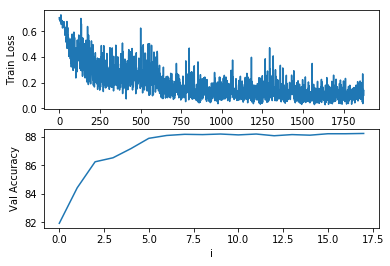

In [34]:
emb_size = 100
model_best = BagOfNgram(len(id2token_n1), emb_size)
test_acc, model = test_proc(model_best, train_loader_n1, val_loader_n1, test_loader_n1, 0.01, True, 3, 'Adam', 0.1, pl=True, pl_val=True)

In [325]:
model.eval()
index = []
for data, lengths, labels in val_loader_n1:
    data_batch, length_batch, label_batch = data, lengths, labels
    outputs = F.softmax(model(data_batch, length_batch), dim=1)
    predicted = outputs.max(1, keepdim=True)[1]
    
    index += (predicted.numpy() == labels.view_as(predicted).numpy()).tolist()
    
correct_index = []
wrong_index = []
for i, val in enumerate(index):
    if val[0] == True:
        correct_index.append(i)
    else:
        wrong_index.append(i)

### 3 correct predictions

In [335]:
three_list = [i for i in np.random.choice(correct_index, 3)]
for i in three_list:
    print(val_data[i]+'\n')

Surprisingly good early effort from Alfred Hitchcock. One of the only original screenplays written by Hitchcock himself, this film shows remarkable story structure. It kicks off with a rousing boxing match in which carnival champ "One Round" Jack loses to a challenger from the audience who happens to be a professional prizefighter. The movie then slows down to develop the characters and introduce a love triangle between Jack, his girl and the professional boxer. The rest of the film is a dramatic buildup to the rematch between the two men, this time for the heavyweight crown. Even in this early film, Hitchcock shows his talent for meaningful cinematography and prop placement. An armband bought for the girl by the boxer continues to pop up throughout the movie as a symbol of her unfaithfulness. The only big detractor of this film is that the art of filming a boxing match had not yet been perfected in 1927. The final match, as a result, ends up being somewhat anticlimactic. The story, th

### 3 incorrect predictions

In [336]:
three_list = [i for i in np.random.choice(wrong_index, 3)]
for i in three_list:
    print(val_data[i]+'\n')

I'm basing this on my observations of one episode I saw last night (9/27/06). I don't think I'll be watching again. The acting was totally wooden, the plot completely predictable, the ending totally unrealistic -- I mean who would believe a 30 million dollar judgment for the death of a recovering drug addict with terminal cancer? The lead actor (Victor Garber) seemed so uncomfortable, almost embarrassed in his role -- perhaps he realized how bad the writing was!! I fully realize that the drama offered this season is pretty poor, but they can surely find better writers. Maybe they are outsourcing the writing to India or China!! I'll bet we won't be seeing this one next season!

I LOVE Don Knotts, let me just say that up-front! He is an enormous talent and the best at what he does, which is portray a nervous, lovably befuddled loser thrown into a position of authority. He is fabulous in this role as Roy Fleming, the Reluctant Astronaut, but the film is pretty dull, really, even though as